In [1]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import collections
import os
import pymysql
import random
import urllib
import zipfile
from six.moves import xrange
import numpy as np
import tensorflow as tf

# Training Parameters
learning_rate = 0.1 #learning rate
batch_size = 128
num_steps = 990000 #一It has to be three times output_STEP, to find the best number of iterations to change here.
output_step = 330000 # 3Xouput=num
display_step = 10000  # Display the loss value 
eval_step = 100000   # The number of iterations after which approximate words for evaluation parameters appear
#eval_step = 20000 

# evaluation parameter
eval_words = ['刘备', '孙权', '曹操', '诸葛亮', '夏侯惇'] #Verify that the database exists

# Word2Vec 参数
max_vocabulary_size = 50000 # The total number of different words in a vocabulary.
min_occurrence = 2          # Delete all words that occur less than n times
num_sampled = 64            # Number of negative samples
skip_window = 5             # How many words to consider on each side from word2vec
embedding_size = 200        # The larger the dimension is, the more accurate it will be. However, the calculation will be larger and time-consuming
num_skips = 2               # The number of times input generated labels are reused


In [2]:
# -*- coding: utf-8 -*-
import pymysql
#Obtaining data
def get_data(sql):
    db = pymysql.connect(host="localhost", user="root",password= "wzq19970405",database= "sanguoyanyi", charset='utf8' ) # open mysql connect
    cursor = db.cursor()          # Use the cursor() method to get the operation cursor
    cursor.execute(sql)           # do 
    results = cursor.fetchall()  # Gets a list of all records
    cursor.close()               #Close a resource Connection
    db.close()
    return results

In [3]:
import sys
import jieba
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
from IPython.core.interactiveshell import InteractiveShell
from gensim.models import Word2Vec  

def read_words(path): # Load text, remove whitespace
    lines = []
    with open (path,'r',encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if len(line) != 0:
                lines.append(line)
        return lines
    

def division_entity(path): # Climb to the entity
    with open(path, "r",encoding='utf-8') as f:
        for line in f.readlines():
            line = line.strip('\n')
            entity_list = line.split("、")
            for entity in entity_list:
                jieba.suggest_freq(entity,True) #Adjust the frequency of individual words so that they cannot be separated.

def stop_words(path): #Load the list of stop words
    with open (path,'r',encoding='utf-8') as f:
        return [line.strip() for line in f]
    

def cut_words(ready_words):# Word Segmentation
    sentences = [jieba.lcut(line) for line in ready_words]
    sens = []
    for sentence in sentences:
        sen = []
        for word in sentence:
            if word not in stop_words:
                sen.append(word)
        sens.extend(sen) #When you don't count word frequency 不统计词频的时候
        #sens.append(sen) # When you count the frequency of words 统计词频的时候
    return sens

C:\Users\wzq10\AppData\Roaming\Python\Python37\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used


In [4]:
ready_words = read_words('../三国演义.txt') #数据文档三国演义
stop_words = stop_words('../停用词.txt') # 停用词文档
division_entity('../人员表.txt') # 实体命名文档
token = cut_words(ready_words) # 将处理好的词放在token中

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\wzq10\AppData\Local\Temp\jieba.cache
Loading model cost 0.649 seconds.
Prefix dict has been built successfully.


In [8]:
#将分词结果变成一个列表
c=[]
for sentence in token:
    for word in sentence:
        if word.strip() != "":
            c.append(word.strip())

In [11]:
#top5= Counter(c).most_common(100)
#print(top5)

[('曹操', 1048), ('刘备', 480), ('孙权', 389), ('司马懿', 343), ('诸葛亮', 275), ('东吴', 274), ('蜀汉', 269), ('袁绍', 237), ('将军', 205), ('曹爽', 182), ('关羽', 171), ('汉中', 171), ('魏国', 169), ('曹睿', 140), ('蜀', 137), ('曹丕', 136), ('姜维', 135), ('荆州', 130), ('司马昭', 129), ('大军', 126), ('董卓', 124), ('邓艾', 122), ('曹魏', 110), ('吕布', 104), ('天下', 103), ('朝廷', 101), ('洛阳', 98), ('长安', 98), ('儿子', 96), ('劝', 96), ('建安', 95), ('钟会', 95), ('进攻', 93), ('诸葛恪', 91), ('听说', 90), ('建议', 89), ('陆逊', 89), ('任命', 87), ('记载', 85), ('部下', 85), ('刘禅', 85), ('兵', 83), ('淮南', 83), ('马超', 82), ('司马师', 82), ('刺史', 80), ('杀', 79), ('明白', 79), ('去世', 78), ('使者', 77), ('刘表', 77), ('死', 76), ('对手', 76), ('益州', 76), ('反叛', 75), ('三国', 73), ('大将军', 73), ('袁术', 73), ('刘璋', 73), ('成都', 71), ('对此', 70), ('一带', 69), ('里', 68), ('周瑜', 68), ('听', 67), ('军粮', 67), ('李', 67), ('城', 67), ('韩遂', 67), ('魏军', 66), ('地方', 65), ('确实', 65), ('孙策', 65), ('合肥', 65), ('动手', 64), ('北伐', 63), ('太守', 62), ('催', 62), ('许昌', 61), ('北方', 60), ('军事', 60), ('担心

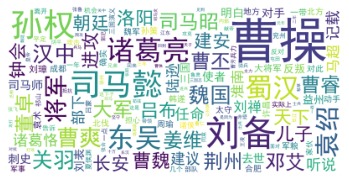

In [13]:
dic_tf = {}
for w in c:
    if  len(w) >= 2:
        dic_tf[w] = dic_tf.get(w,0) + 1
wc = WordCloud(font_path = 'simhei.ttf',
                   background_color="white",  # background color
                   max_words=150 # Maximum number of words displayed in the word cloud
                   )
 
wc.fit_words(dic_tf)
plt.figure()
plt.imshow(wc)
plt.axis("off")
plt.show()

In [5]:
# Dictionary-building
# Build a dictionary and replace less frequent words with the marker
count = [('低频率词', -1)]
# Retrieve the most common words
count.extend(collections.Counter(token).most_common(max_vocabulary_size - 1))
# Delete samples less than the number of'min_occurrence'
for i in range(len(count) - 1, -1, -1):
    if count[i][1] < min_occurrence:
        count.pop(i)
    else:
        break
vocabulary_size = len(count)# Count the number of words in the word list
wid = dict() #Assign an ID to each word
for i, (word, _)in enumerate(count): #one0hot 
    wid[word] = i

datalist = list()
dipin = 0

for word in token:# Retrieve the word ID, or specify index 0 ('UNK') if it is not in the dictionary
    index = wid.get(word, 0)
    if index == 0:
        dipin += 1
    datalist.append(index)
count[0] = ('低频率词', dipin)
jieya = dict(zip(wid.values(), wid.keys()))

print("##########################################")
print("Total word count:", len(token))
print("Number of non-repeated words:", len(set(token)))
print("Number of valid words:", vocabulary_size)
print("Maximum words:", count[1:11])
print("##########################################")

#A glossary stores data
sign = 0
db = pymysql.connect(host="localhost", user="root",password= "wzq19970405",database= "sanguoyanyi", charset='utf8' )
cursor = db.cursor()
SQL_in = "INSERT INTO key_words (key_word,word_id,frequency) values(%s,%s,%s)"
for i in range(len(count)):
    sign = sign + 1
    if count[i][0] != '低频率词' and count[i][0] != 'null':
        key_word = count[i][0]
        frequency = count[i][1]
        word_id = np.array([wid[w] for w in [key_word]])[0]
        cursor.execute(SQL_in,[key_word,str(word_id),str(frequency)])
    if sign % 10000 == 0 :
        print("The dictionary has been stored：",sign)
db.commit()
cursor.close()
db.close()

##########################################
Total word count: 62154
Number of non-repeated words: 16747
Number of valid words: 7437
Maximum words: [('曹操', 1048), ('刘备', 480), ('孙权', 389), ('司马懿', 343), ('诸葛亮', 275), ('东吴', 274), ('蜀汉', 269), ('袁绍', 237), ('将军', 205), ('曹爽', 182)]
##########################################


In [6]:
#  Function to generate a training set for the training program model
flag = 0
def next_batch(batch_size, num_skips, skip_window):   # Generate training batches for skip-Gram models
    global flag
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1                        # Get the window length (current word left and right + current word)
    buffer = collections.deque(maxlen=span)
    if flag + span > len(datalist):
        flag = 0
    buffer.extend(datalist[flag:flag + span])
    flag += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if flag == len(datalist):
            buffer.extend(datalist[0:span])
            flag = span
        else:
            buffer.append(datalist[flag])
            flag += 1
    flag = (flag + len(datalist) - span) % len(datalist)       #Backtrack a bit to avoid skipping words at the end of the batch
    return batch, labels

# Modeling network
# Ensure that the following operations and variables are allocated on the CPU
with tf.device('/cpu:0'):
    #  embedding vector.
    embedding = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]),name="embedding")
    # Construct the variable of NCE loss
    nce_weights = tf.Variable(tf.random.normal([vocabulary_size, embedding_size]),name="nce_weights")
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]),name="nce_biases")

def get_embedding(x):
    with tf.device('/cpu:0'):
        x_embed = tf.nn.embedding_lookup(embedding, x) # Look for the corresponding embedding vector for each sample in X
        return x_embed

def nce_loss(x_embed, y):
    with tf.device('/cpu:0'):
        y = tf.cast(y, tf.int64)               # Calculate the average NCE loss for batch processing
        loss = tf.reduce_mean(
            tf.nn.nce_loss(weights=nce_weights,#weight
                           biases=nce_biases,  #bias
                           labels=y,           #label
                           inputs=x_embed,     #input vector
                           num_sampled=num_sampled, #The number of negative samples
                           num_classes=vocabulary_size)) # Class Number
        return loss

def evaluate(x_embed):  # Evaluate the cosine similarity between the input data embedding and each embedding vector
    with tf.device('/cpu:0'):
        x_embed = tf.cast(x_embed, tf.float32)
        x_embed_norm = x_embed / tf.sqrt(tf.reduce_sum(tf.square(x_embed)))
        embedding_norm = embedding / tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keepdims=True), tf.float32)
        cosine_similarity = tf.matmul(x_embed_norm, embedding_norm, transpose_b=True)
        return cosine_similarity

optimizer = tf.optimizers.SGD(learning_rate)  # Defining the optimizer
def run_optimization(x, y):                  # optimization procedure
    with tf.device('/cpu:0'):
        with tf.GradientTape() as g:        # Encapsulate the calculations in GradientTape for automatic differentiation
            emb = get_embedding(x)
            loss = nce_loss(emb, y)
        gradients = g.gradient(loss, [embedding, nce_weights, nce_biases])  # Gradient computation
        optimizer.apply_gradients(zip(gradients, [embedding, nce_weights, nce_biases])) # Update W and B by gradients


testlist = np.array([wid[w] for w in eval_words]) # Words for testing

# Train for a given number of steps
save_falg = 0
for step in xrange(1, num_steps + 1):
    batch_x, batch_y = next_batch(batch_size, num_skips, skip_window)
    run_optimization(batch_x, batch_y)
            
    if step % display_step == 0 or step == 1:
        loss = nce_loss(get_embedding(batch_x), batch_y)
        print("iterations: %i,  Loss: %f" % (step, loss))
                
    # evaluate
    if step % eval_step == 0 or step == 1:
        print("Data calculation evaluation value...")
        similarity = evaluate(get_embedding(testlist)).numpy()
        for i in xrange(len(eval_words)):
            num_sim = 8  # The number of words that are most similar
            nearest = (-similarity[i, :]).argsort()[1:num_sim + 1]
            log_str = '"%s" Similar words:' % eval_words[i]
            for k in xrange(num_sim):
                log_str = '%s %s,' % (log_str, jieya[nearest[k]])
            print(log_str)


    #storage
    if step % output_step == 0 :
        save_falg = save_falg + 1
        SQL = "SELECT key_word FROM key_words"
        id_list = get_data(SQL)
        if save_falg == 1:
            SQL_save = "UPDATE key_words SET `stageone` = %s WHERE key_word = %s"
        elif save_falg == 2:
            SQL_save = "UPDATE key_words SET `stagetwo` = %s WHERE key_word = %s"
        else:
            SQL_save = "UPDATE key_words SET `final` = %s WHERE key_word = %s"
        print("start",save_falg*330000,"in database")
        for row in id_list:
            key_word = row[0]
            test_word = np.array([wid[w] for w in [key_word]])
            value = get_embedding(test_word).numpy().tolist()
            
            db = pymysql.connect(host="localhost", user="root",password= "wzq19970405",database= "sanguoyanyi", charset='utf8' )
            cursor = db.cursor()
            cursor.execute(SQL_save,[str(value[0]),key_word])
            db.commit()
            cursor.close()
            db.close()
            
        print("finish",save_falg*330000,"in database")
            


iterations: 1,  Loss: 449.285156
Data calculation evaluation value...
"刘备" Similar words: 信念, 三台, 蔡氏, 卫队, 麾盖, 蒲坂津, 上计, 凌统,
"孙权" Similar words: 大限, 战舰, 黄崇, 六月, 没太, 不及, 钱粮, 喘息,
"曹操" Similar words: 淮阴, 陈琳, 费袆, 诱敌深入, 汉灵帝, 人质, 泄密, 汉兴,
"诸葛亮" Similar words: 败得, 招待, 吝啬, 牧马, 首领, 直, 愣, 昔,
"夏侯惇" Similar words: 节钺, 对准, 作乱, 历次, 兵不血刃, 带领, 老弟, 不息,
iterations: 10000,  Loss: 34.610268
iterations: 20000,  Loss: 16.274124
iterations: 30000,  Loss: 12.098848
iterations: 40000,  Loss: 9.584636
iterations: 50000,  Loss: 12.765849
iterations: 60000,  Loss: 8.427128
iterations: 70000,  Loss: 9.969606
iterations: 80000,  Loss: 9.891467
iterations: 90000,  Loss: 8.005532
iterations: 100000,  Loss: 7.886846
Data calculation evaluation value...
"刘备" Similar words: 曹操, 孙权, 东吴, 荆州, 关羽, 汉中, 魏国, 低频率词,
"孙权" Similar words: 东吴, 曹操, 刘备, 司马懿, 低频率词, 关羽, 魏国, 大军,
"曹操" Similar words: 孙权, 低频率词, 袁绍, 刘备, 东吴, 将军, 关羽, 司马懿,
"诸葛亮" Similar words: 蜀汉, 低频率词, 魏国, 东吴, 曹操, 司马懿, 孙权, 汉中,
"夏侯惇" Similar words: 袁绍, 曹操, 关羽, 汉中, 吕布, 孙权, 刘备, 儿子,
